# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = 2500000)["train"]
print(training_data.columns)

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [3]:
training_data = preprocessing.basic_preprocessing(training_data)

In [5]:
training_data["delivery_calendar_days"].describe()

count    2.500000e+06
mean     4.745343e+00
std      3.099595e+00
min     -1.520000e+02
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      2.140000e+02
Name: delivery_calendar_days, dtype: float64

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 672692
declared_handling_days : 12
acceptance_scan_timestamp : 618965
shipment_method_id : 22
shipping_fee : 4584
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 37521
buyer_zip : 38191
category_id : 33
item_price : 22720
quantity : 85
payment_datetime : 2430469
delivery_date : 741
weight : 817
weight_units : 2
package_size : 5
record_number : 2500000
delivery_calendar_days : 148


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (2500000, 20)
training_data.shape after :  (2500000, 78)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1675000, 67), (825000, 67), (1675000,), (825000,))

In [12]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric='logloss')# This loss needs to mirror the loss that Ebay is using.

[10]	training's l2: 8.45909	valid_0's l2: 8.5389
[20]	training's l2: 8.26241	valid_0's l2: 8.36157
[30]	training's l2: 8.19478	valid_0's l2: 8.3118
[40]	training's l2: 8.15718	valid_0's l2: 8.2909
[50]	training's l2: 8.13585	valid_0's l2: 8.28039
[60]	training's l2: 8.12061	valid_0's l2: 8.27533
[70]	training's l2: 8.10648	valid_0's l2: 8.27119
[80]	training's l2: 8.09708	valid_0's l2: 8.26694
[90]	training's l2: 8.08595	valid_0's l2: 8.26187
[100]	training's l2: 8.07731	valid_0's l2: 8.25793


LGBMRegressor(max_depth=-5, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

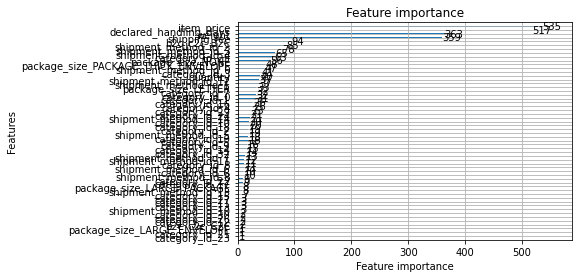

In [13]:
lgb.plot_importance(model)

In [14]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.1569
Testing accuracy 0.1453


In [15]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [18]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [22]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 2500000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


Reading 2500000 rows.
Reading all columns.


In [27]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [28]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [29]:
output_columns_name = "predicted_delivery_date"

In [30]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [31]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [33]:
import pandas as pd

In [49]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

In [50]:
submission

,0,1
0,15000001,2019-11-18
1,15000002,2019-11-30
2,15000003,2019-12-06
3,15000004,2019-12-16
4,15000005,2019-12-22
...,...,...
2499995,17499996,2019-12-24
2499996,17499997,2019-12-09
2499997,17499998,2019-12-08
2499998,17499999,2019-12-12
